# Introduction
Our data set choice is the spotify tracks data set, https://huggingface.co/datasets/maharshipandya/spotify-tracks-dataset. The main features for this dataset are listed in the 'Goal' section. But for concisness, we are mainly studying the genre, the danceability, energy, and explicitness.

##Goal
Goal: Building a recommendation system based on user input for preference and classification purposes based on audio features and available genres. The main features: 'artists', 'popularity', 'duration_ms', 'danceability', 'energy' 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'track_genre' and some others. Using this infromation we can train the model to recommend songs based on user input and the previous classification of songs. In this way, we will achieve our target goal in a very effective and efficient manner.

In [100]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.metrics import silhouette_score, silhouette_samples, rand_score, adjusted_rand_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

# Install Dataset
!pip install datasets

import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import load_dataset
from sklearn.decomposition import TruncatedSVD
from torch.utils.data import DataLoader, TensorDataset

random.seed(42)

In [101]:
# Load Dataset
data = load_dataset("maharshipandya/spotify-tracks-dataset")

In [102]:
# Create DataFrame
df = data['train'].to_pandas()

# Look at DataFrame
df

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,113995,2C3TZjDRiAzdyViavDJ217,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Sleep My Little Boy,21,384999,False,0.172,0.2350,...,-16.393,1,0.0422,0.6400,0.928000,0.0863,0.0339,125.995,5,world-music
113996,113996,1hIz5L4IB9hN3WRYPOCGPw,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Water Into Light,22,385000,False,0.174,0.1170,...,-18.318,0,0.0401,0.9940,0.976000,0.1050,0.0350,85.239,4,world-music
113997,113997,6x8ZfSoqDjuNa5SVP5QjvX,Cesária Evora,Best Of,Miss Perfumado,22,271466,False,0.629,0.3290,...,-10.895,0,0.0420,0.8670,0.000000,0.0839,0.7430,132.378,4,world-music
113998,113998,2e6sXL2bYv4bSz6VTdnfLs,Michael W. Smith,Change Your World,Friends,41,283893,False,0.587,0.5060,...,-10.889,1,0.0297,0.3810,0.000000,0.2700,0.4130,135.960,4,world-music


In [103]:
# Check Feature Counts
df['track_genre'].value_counts()

,count
track_genre,
acoustic,1000
punk-rock,1000
progressive-house,1000
power-pop,1000
pop,1000
...,...
folk,1000
emo,1000
electronic,1000


In [104]:
# Group Features
columns_to_keep = [
    'track_id', 'artists', 'popularity', 'duration_ms', 'danceability', 'energy',
    'loudness', 'speechiness', 'acousticness', 'instrumentalness',
    'liveness', 'valence', 'tempo', 'time_signature', 'track_genre'
]

integer_columns = ['popularity', 'duration_ms', 'danceability', 'energy',
    'loudness', 'speechiness', 'acousticness', 'instrumentalness',
    'liveness', 'valence', 'tempo', 'time_signature']

# Filter DataFrame
df = df[columns_to_keep]
df.head()

,track_id,artists,popularity,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,73,230666,0.676,0.4610,-6.746,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,55,149610,0.420,0.1660,-17.235,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,57,210826,0.438,0.3590,-9.734,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,71,201933,0.266,0.0596,-18.515,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,82,198853,0.618,0.4430,-9.681,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [105]:
# Check Missing Values
df.isnull().sum()

,0
track_id,0
artists,1
popularity,0
duration_ms,0
danceability,0
energy,0
loudness,0
speechiness,0
acousticness,0
instrumentalness,0


Since it appears that only one feature entry has a missing value in the entire dataset, it is easier just to remove it and continue. Note if more values were missing other data imputation techniques could be required, however, this is not the case here so we can proceed with the work.

In [106]:
# Remove Missing Value
df = df.dropna(subset = ['artists'])

Because our end-goal in this project is to be able to recommend a song to the user based based on certain features that they desire, we want to ensure that the potentially most important aspect (the genre), is properly represented in the training data. Because of this, we will now continue by splitting everything so that each genre is properly and proportionally represented in each of the relevant training, testing, and validation sets.

## Limit Genre Popularitly
Since our goal for this project is to recommend a song, and there is an excess of possible songs in the output to be able to recommend it quick and accurately, our next step is to limit the genre by popularity, so that we can reduce the amount of output. Also, our decision to do this is also motivated by the fact that there are some niche genres that most of the population don't listen to, hence we will be eliminating them as needed.

In [107]:
# Calculate the Average Popularity for Each Genre
genre_popularity = df[['track_genre', 'popularity']].groupby('track_genre').mean()

# Sort Genres by Popularity (Descending Order)
genre_popularity_sorted = genre_popularity.sort_values('popularity', ascending = False)

# Select the Most Popular Genres (Top Half)
num_top_genres = len(genre_popularity_sorted) // 2
top_genres = genre_popularity_sorted.head(num_top_genres).index

# Filter the DataFrame by Top Genres
df = df[df['track_genre'].isin(top_genres)]

# Check Genre Results Before and After Filtering
print(f"Original Number of Genres: {len(genre_popularity_sorted)}")
print(f"Number of Genres After Filtering: {len(top_genres)}")

Original Number of Genres: 114
Number of Genres After Filtering: 57


In [108]:
#Split Data into Training, Testing, and Validation Set (Based on Genre)
train_list = []
test_list = []
val_list = []

# Iterate Throguh Each Genre and Create Splits
for genre in df['track_genre'].unique():

    genre_df = df[df['track_genre'] == genre]

    train_genre, temp_genre = train_test_split(genre_df, test_size = 0.4, random_state = 42)

    test_genre, val_genre = train_test_split(temp_genre, test_size = 0.5, random_state = 42)

    train_list.append(train_genre)
    test_list.append(test_genre)
    val_list.append(val_genre)

# Create Final Splits (Avoiding Duplicate Indices)
train_df = pd.concat(train_list).reset_index(drop=True)
test_df = pd.concat(test_list).reset_index(drop=True)
val_df = pd.concat(val_list).reset_index(drop=True)

# Print the Final Training, Testing, and Validation Splits
print("Training Set Size:", len(train_df))
print("Testing Set Size:", len(test_df))
print("Validation Set Size:", len(val_df))

Training Set Size: 34199
Testing Set Size: 11400
Validation Set Size: 11400


In [109]:
# Look at DataFrame
df

,track_id,artists,popularity,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,73,230666,0.676,0.4610,-6.746,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,55,149610,0.420,0.1660,-17.235,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,57,210826,0.438,0.3590,-9.734,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,71,201933,0.266,0.0596,-18.515,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,82,198853,0.618,0.4430,-9.681,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,2C3TZjDRiAzdyViavDJ217,Rainy Lullaby,21,384999,0.172,0.2350,-16.393,0.0422,0.6400,0.928000,0.0863,0.0339,125.995,5,world-music
113996,1hIz5L4IB9hN3WRYPOCGPw,Rainy Lullaby,22,385000,0.174,0.1170,-18.318,0.0401,0.9940,0.976000,0.1050,0.0350,85.239,4,world-music
113997,6x8ZfSoqDjuNa5SVP5QjvX,Cesária Evora,22,271466,0.629,0.3290,-10.895,0.0420,0.8670,0.000000,0.0839,0.7430,132.378,4,world-music
113998,2e6sXL2bYv4bSz6VTdnfLs,Michael W. Smith,41,283893,0.587,0.5060,-10.889,0.0297,0.3810,0.000000,0.2700,0.4130,135.960,4,world-music


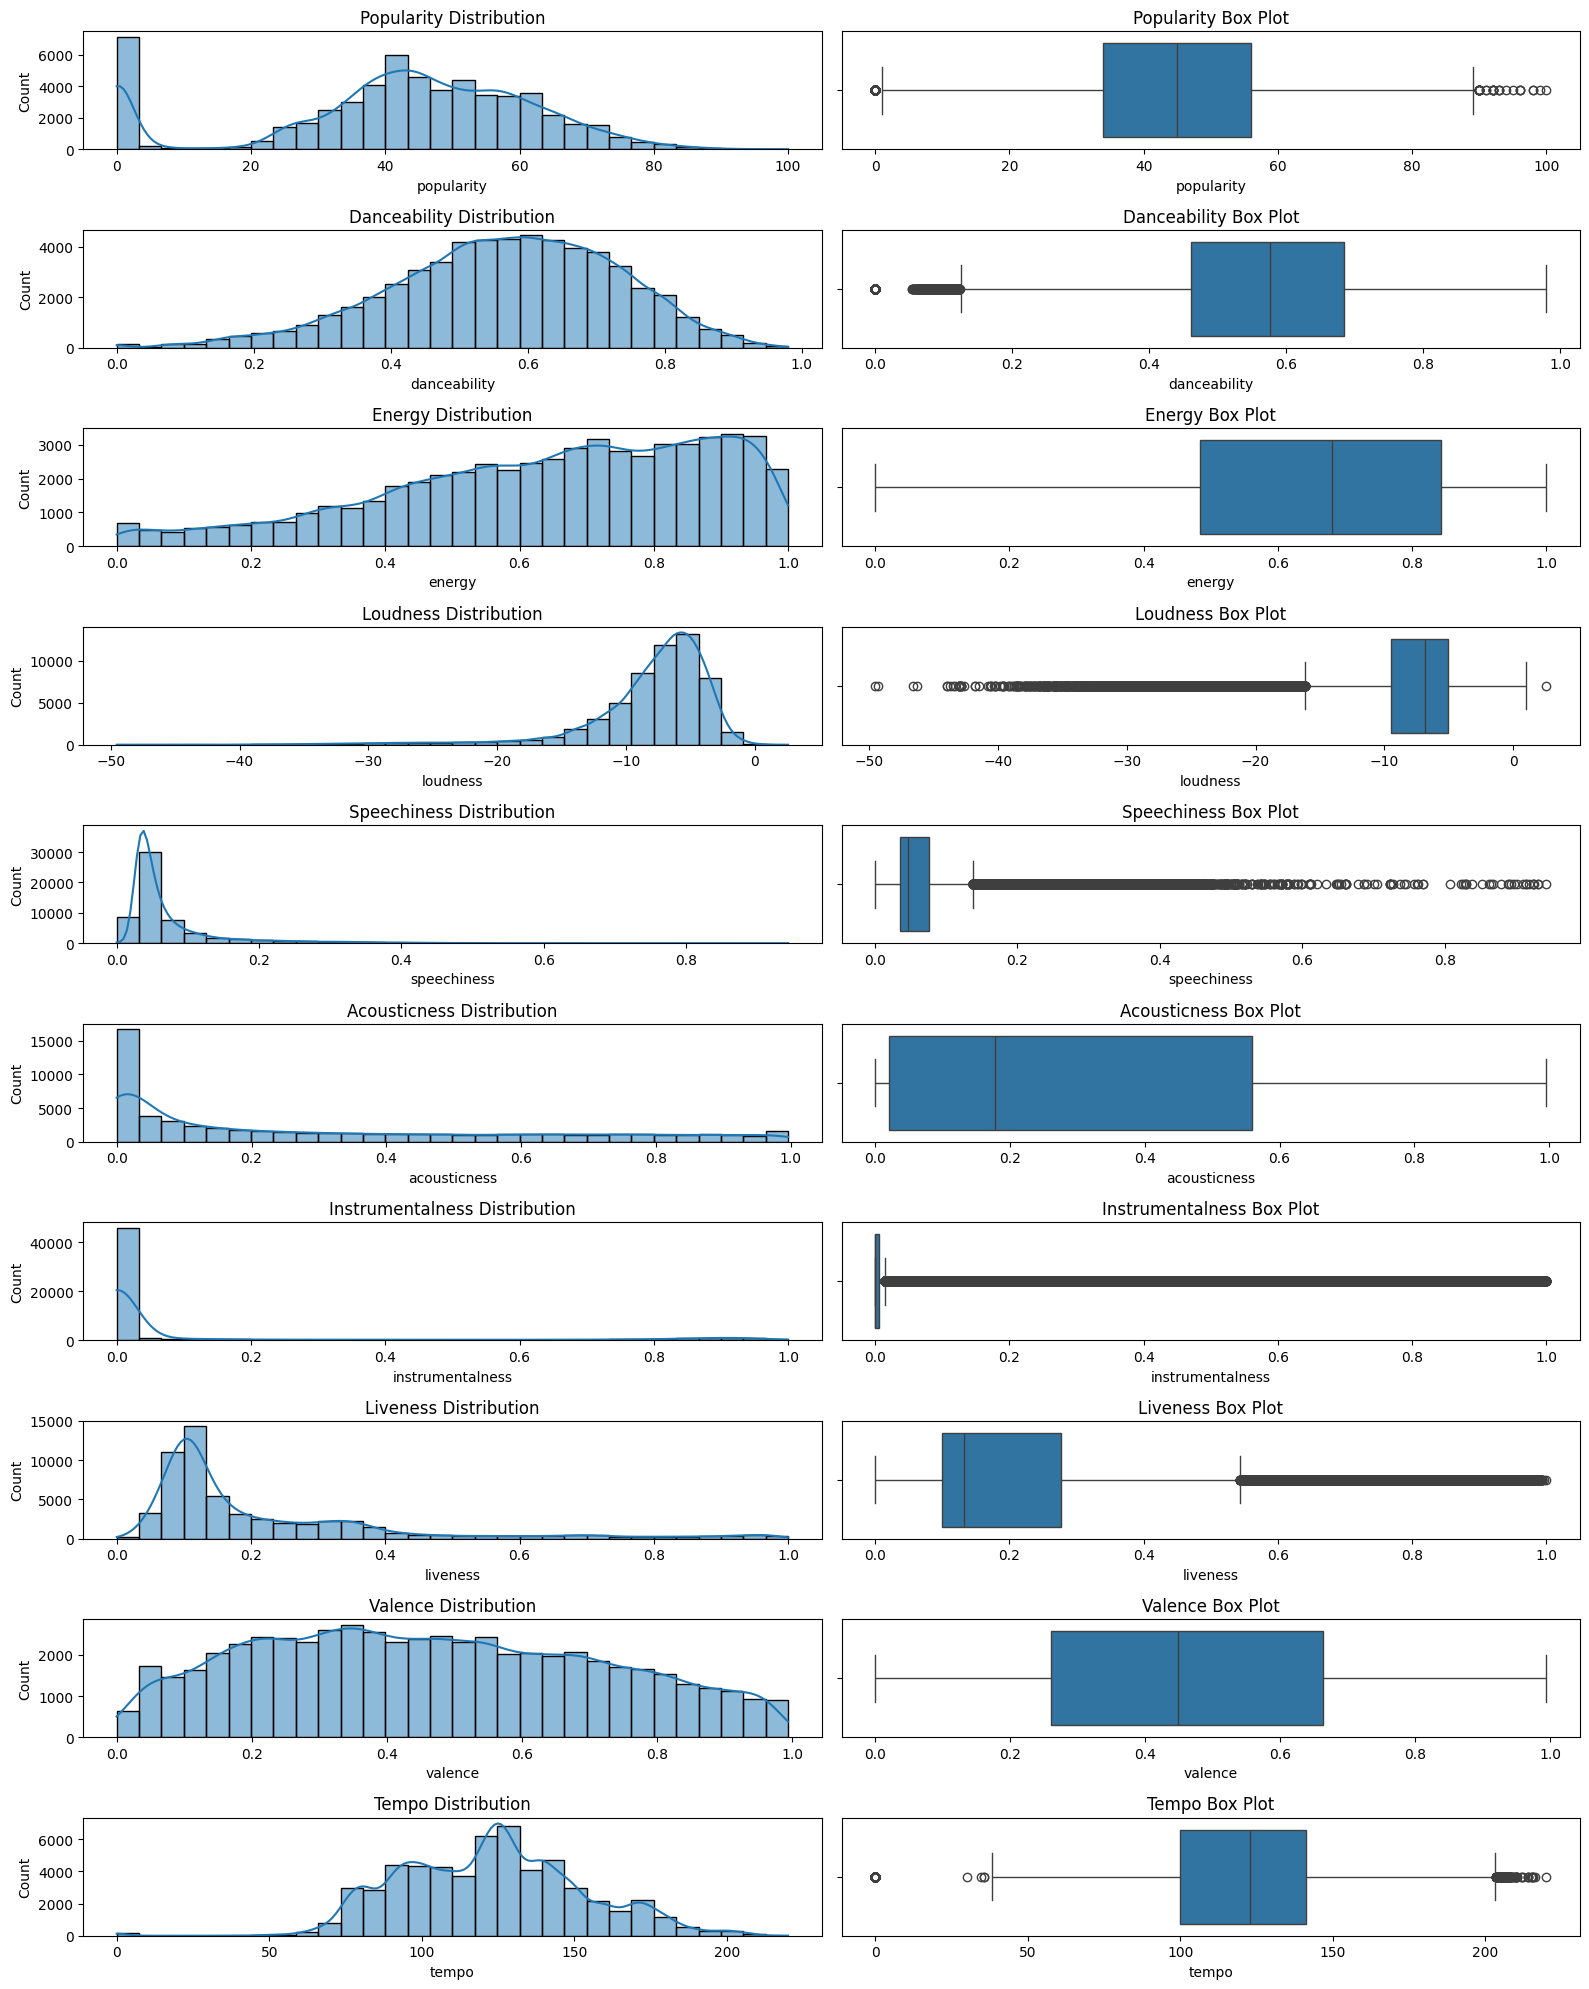

In [110]:
# Create List of Numerical Features
numerical_features = [
    'popularity', 'danceability', 'energy', 'loudness', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'
]

# Set Figure Size
plt.figure(figsize = (16, 20))

# Iterate Through Each Numerical Feature and Visualize
for i, feature in enumerate(numerical_features, 1):

    # Create Histogram Plot
    plt.subplot(len(numerical_features), 2, 2 * i - 1)
    sns.histplot(df[feature], kde = True, bins = 30)
    plt.title(f'{feature.capitalize()} Distribution')

    # Create Box Plot
    plt.subplot(len(numerical_features), 2, 2 * i)
    sns.boxplot(x = df[feature])
    plt.title(f'{feature.capitalize()} Box Plot')

# Display Plots
plt.tight_layout()
plt.show()

# Regression Analysis
For this regression analysis, we will be using `danceability` as the response variable, along with `energy` and `valence` as the predictor variables. Note that other combinations of variables could be chosen, but this is one example that we believe will provide useful insights.

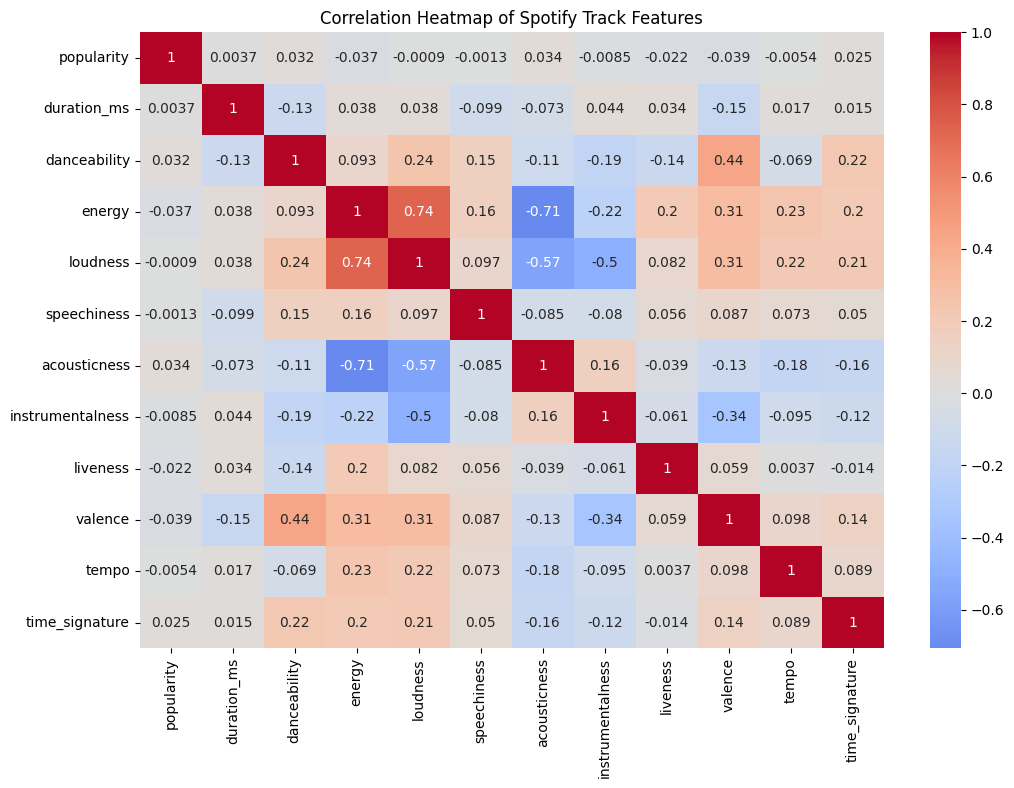

In [111]:
# Calculate Correlation Matrix
correlation_matrix = df[integer_columns].corr()

# Create and Display Correlation Heatmap
plt.figure(figsize = (12, 8))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', center = 0)
plt.title("Correlation Heatmap of Spotify Track Features")
plt.show()

## Linear Regression

In [112]:
# Prepare Data
X_train = df[['energy', 'valence']]
y_train = df['danceability']
X_val = df[['energy', 'valence']]
y_val = df['danceability']

# Create and Train the Model
model = LinearRegression()
model.fit(X_train, y_train)

# Make Predictions
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

# Calculate Evaluation Metrics
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

# Print The Results
print("Linear Regression Results")
print("Training MSE:", train_mse)
print("Training R-Squared:", train_r2)
print("Validation MSE:", val_mse)
print("Validation R-Squared:", val_r2)

Linear Regression Results
Training MSE: 0.021916262217307848
Training R-Squared: 0.19149411094983093
Validation MSE: 0.021916262217307848
Validation R-Squared: 0.19149411094983093


## Regression Interpretation
The Training MSE is relatively low (0.0219), which suggests that the model fits the training data very well. However, the Training R-Squared value (0.1915) indicates that only about 19.15% of the variance in danceability is explained by energy and valence in the training set. This means that while the predictions are close to the actual values in terms of squared errors, the overall model might not capture all the significant patterns or relationships.
Similarly, the Validation MSE (0.0219) and Validation R-squared (0.1915) show consistent performance on the unseen data. This close match between training and validation metrics indicates that the model generalizes very well, without any overfitting. In this way, the low R² values (both for the training and validation sets) suggest that the chosen predictors (energy and valence) don't explain a relevant proportion of the variability in danceability. This implies that other features (e.g., loudness, tempo, or other variables in the dataset) might contribute more significantly to predicting danceability. As such, including additional features or using non-linear models might improve the performance. From here, despite the low R², the model can still provide valuable insights into trends or correlations between the predictors and response variable. In summary, the results suggest that while energy and valence have some predictive power, they are not the sole determinants of danceability.

## Logistic Regression

In [113]:
# Define Features and Threshold
features = ['energy', 'loudness', 'valence']
threshold = 0.5

# Create Binary Response Variable
df['danceability'] = (df['danceability'] > threshold).astype(int)
X = df[features]
y = df['danceability']

# Split Data Into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=37)

# Create Logistic Regression Model
lr = LogisticRegression(solver = 'liblinear')
lr.fit(X_train, y_train)

# Model Coefficients and Intercept
lr.intercept_, lr.coef_

# Make Predictions
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_val)

In [114]:
# Create Confusion Matrix
conf_matrics = metrics.confusion_matrix(y_val, y_test_pred)
conf_matrics

array([[1166, 2568],
       [ 818, 6848]])

Text(50.722222222222214, 0.5, 'Actual')

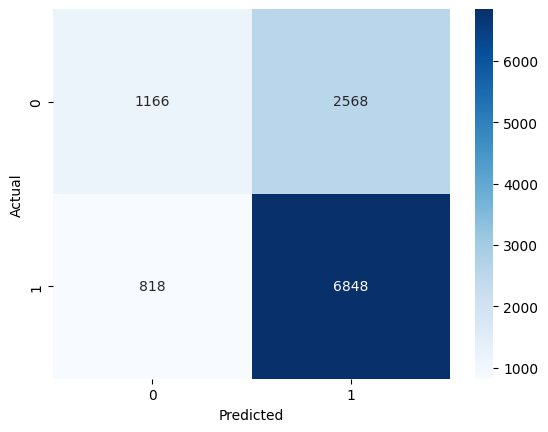

In [115]:
# Create Heat Map of Confusion Matrix
sns.heatmap(conf_matrics, annot = True, fmt = 'd', cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')

### True Positive

In [116]:
# Calculate and Display True Positive
metrics.recall_score(y_val, y_test_pred, pos_label = 1)

0.8932950691364466

### True Negative

In [117]:
# Calculate and Display True Negative
metrics.recall_score(y_val, y_test_pred, pos_label = 0)

0.31226566684520624

### Prediction Accuracy and Error

In [118]:
# Calculate Training and Testing Accuracy and Error
train_accuracy = metrics.accuracy_score(y_train, y_train_pred)
test_accuracy = metrics.accuracy_score(y_val, y_test_pred)

train_error = 1 - train_accuracy
test_error = 1 - test_accuracy

# Print Training and Testing Accuracy and Error
print("Train Accuracy:", train_accuracy)
print("Train Error:", train_error)
print("Test Accuracy:", test_accuracy)
print("Test Error:", test_error)

Train Accuracy: 0.7012434483212351
Train Error: 0.2987565516787649
Test Accuracy: 0.7029824561403509
Test Error: 0.29701754385964907


### Calculating and Plotting ROC curves

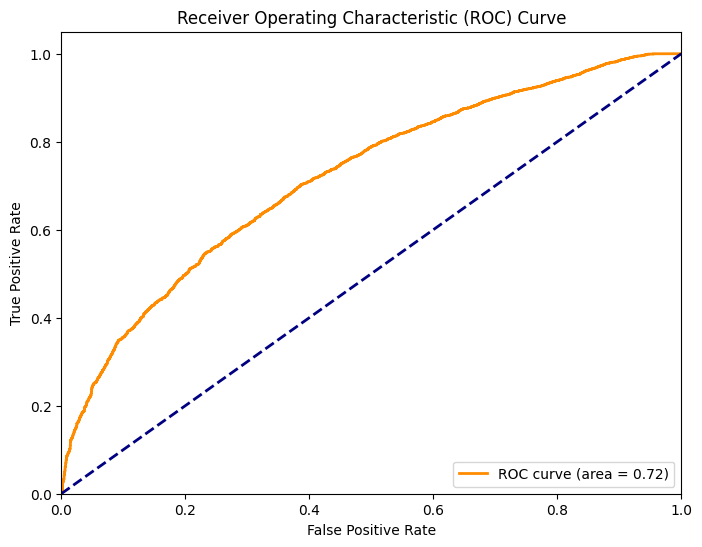

In [119]:
# Calculate ROC Metrics
y_val_p = lr.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_val, y_val_p)
roc_auc = metrics.roc_auc_score(y_val, y_val_p)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color = 'darkorange', lw = 2, label = f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0,1],[0,1], color = 'navy', lw = 2, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc = 'lower right')
plt.show()

### Cross-Val

In [120]:
# Calculate and Print Cross-Validation Scores and Mean Accuracy
cross_val_scores = cross_val_score(lr, X, y, cv = 5, scoring = 'accuracy')

print("Cross-Validation Scores:", cross_val_scores)
print("Mean Accuracy:", np.mean(cross_val_scores))

Cross-Validation Scores: [0.71938596 0.67596491 0.70008772 0.67789474 0.70400912]
Mean Accuracy: 0.6954684913881335


In [121]:
# Calculate and Print the Optimal Threshold
idx = np.argmax(tpr)
optimal_threshold = thresholds[idx]
optimal_threshold

0.10010867539047945

We chose the threshold based off of the threshold that maximizes the true positive rate, which is what we care most about for this core project.

#Regularization
## Ridge Regression

In [122]:
# Create and Train the Ridge Regression Model
ridge_model = Ridge(alpha = 1.0)
ridge_model.fit(X_train, y_train)

# Make Predictions with Ridge Regression
y_train_pred_ridge = ridge_model.predict(X_train)
y_val_pred_ridge = ridge_model.predict(X_val)

# Calculate Evaluation Metrics for Ridge Regression
train_mse_ridge = mean_squared_error(y_train, y_train_pred_ridge)
train_r2_ridge = r2_score(y_train, y_train_pred_ridge)
val_mse_ridge = mean_squared_error(y_val, y_val_pred_ridge)
val_r2_ridge = r2_score(y_val, y_val_pred_ridge)

# Print the Results for Ridge Regression
print("Ridge Regression Results")
print("Training MSE:", train_mse_ridge)
print("Training R-squared:", train_r2_ridge)
print("Validation MSE:", val_mse_ridge)
print("Validation R-squared:", val_r2_ridge)

Ridge Regression Results
Training MSE: 0.1891167591639501
Training R-squared: 0.14122136617805103
Validation MSE: 0.1906257252923096
Validation R-squared: 0.13453784205815889


## Regularization Interpretation
Based on the metrics, the model shows evidence of underfitting. The training and validation metrics are nearly identical, with both of the MSE and R² values showing no significant discrepancy, which indicates that the model is not overfitting. However, the R² values for both the training (14.12%) and validation (13.45%) sets are quite low, suggesting that the model is unable to explain much of the variability in danceability. This implies that the predictors used (energy and valence) do not capture enough information to make accurate predictions and that the model may be too simple to represent the underlying relationships in the data. Including additional predictors or using more sophisticated models could be the solution to address this underfitting issue. Nevertheless, the results still provided some relevant insights into the trends in the relevant data.

# KNN and Random Forest Algorithm

### Feature Selection

In [123]:
# Select Features and Binarize Danceability (Threshold = 0.5)
features = ['energy', 'loudness', 'valence']
X_train = train_df[features]
y_train = (train_df['danceability'] > 0.5).astype(int)
X_val = val_df[features]
y_val = (val_df['danceability'] > 0.5).astype(int)

### Model Training and Evaluation

In [124]:
# Initialize and Train the KNN Classifier.
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)

# Model Predictions
y_train_pred_knn = knn.predict(X_train)
y_val_pred_knn = knn.predict(X_val)
y_val_proba_knn = knn.predict_proba(X_val)[:, 1]

# Calculate Evaluation Metrics for KNN
train_accuracy_knn = accuracy_score(y_train, y_train_pred_knn)
train_precision_knn = precision_score(y_train, y_train_pred_knn)
train_recall_knn = recall_score(y_train, y_train_pred_knn)
train_f1_knn = f1_score(y_train, y_train_pred_knn)

val_accuracy_knn = accuracy_score(y_val, y_val_pred_knn)
val_precision_knn = precision_score(y_val, y_val_pred_knn)
val_recall_knn = recall_score(y_val, y_val_pred_knn)
val_f1_knn = f1_score(y_val, y_val_pred_knn)

# Print KNN Evaluation Metrics
print("KNN Classifier Metrics")
print("Training Accuracy:", train_accuracy_knn)
print("Training Precision:", train_precision_knn)
print("Training Recall:", train_recall_knn)
print("Training F1 Score:", train_f1_knn)
print("\nValidation Accuracy:", val_accuracy_knn)
print("Validation Precision:", val_precision_knn)
print("Validation Recall:", val_recall_knn)
print("Validation F1 Score:", val_f1_knn)

KNN Classifier Metrics
Training Accuracy: 0.8180356150764643
Training Precision: 0.8399676375404531
Training Recall: 0.9015674525639356
Training F1 Score: 0.8696781219241482

Validation Accuracy: 0.7342982456140351
Validation Precision: 0.7834712755598832
Validation Recall: 0.8373877975803304
Validation F1 Score: 0.8095327925548639


### KNN Metrics Discussion
The KNN model demonstrates solid performance based on the evaluation metrics provided. The training accuracy of 81.80% suggests that the model captures patterns in the training data effectively, while the validation accuracy of 73.43% indicates a moderate generalizability to unseen data. The training precision of 84.00% and recall of 90.16% highlight the model's ability to correctly identify the true positives with relatively few false positives. These metrics result in a training F1 score of 86.97%, which balances precision and recall. In this way, these results are relevant.

For validation, the precision of 78.35% shows a slight drop compared to training, meaning there are more false positives on new data. However, the validation recall remains high at 83.74% suggests that the model is still adept at capturing true positives. The validation F1 score of 80.95% reflects a decent balance between precision and recall, although it slightly underperforms compared to training data, as can be expected here.

This performance gap between training and validation metrics could indicate mild overfitting, where the model is slightly too tailored to training data. Despite this, the KNN classifier remains an effective baseline model for predicting danceability and has provided useful/relevant results.

### Confusion Matrix and ROC curve for KNN

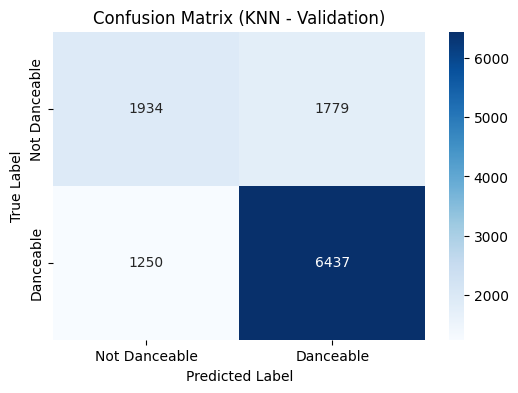

In [125]:
# Create Confusion Matrix
conf_matrix_knn = confusion_matrix(y_val, y_val_pred_knn)

# Create Heat Map of Confusion Matrix
plt.figure(figsize = (6, 4))
sns.heatmap(conf_matrix_knn, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = ['Not Danceable', 'Danceable'], yticklabels = ['Not Danceable', 'Danceable'])
plt.title('Confusion Matrix (KNN - Validation)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

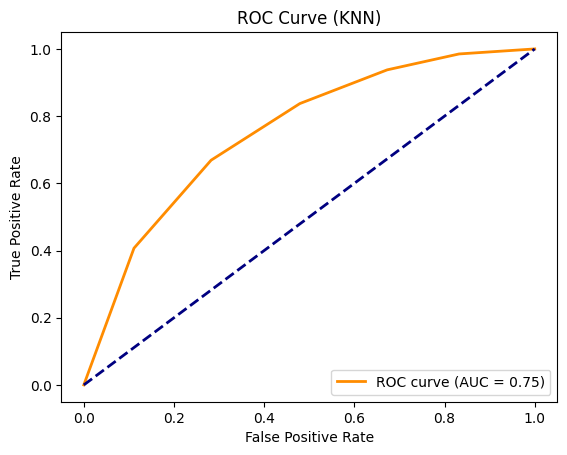

In [126]:
# Calculate ROC Metrics
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_val, y_val_proba_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Plot ROC Curve
plt.figure()
plt.plot(fpr_knn, tpr_knn, color = 'darkorange', lw = 2, label = f'ROC curve (AUC = {roc_auc_knn:.2f})')
plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (KNN)')
plt.legend(loc = "lower right")
plt.show()

### Cross-Validation KNN

In [127]:
# Calculate and Print Cross-Validation Scores and Mean Accuracy
cv_auc_knn = cross_val_score(knn, X_val, y_val, cv = 5, scoring = 'roc_auc')

print("5-Fold Cross-Validation AUC Scores (KNN):", cv_auc_knn)
print("Mean AUC (KNN):", np.mean(cv_auc_knn))

5-Fold Cross-Validation AUC Scores (KNN): [0.72080997 0.66042771 0.67201668 0.64089429 0.70909511]
Mean AUC (KNN): 0.6806487514473731


## Random Forest Model
### Training and Evaluation

In [128]:
# Initialize Random Forest Classifier
rf = RandomForestClassifier(n_estimators = 100, random_state = 37)
rf.fit(X_train, y_train)

# Train the Model and Make Predictions
y_train_pred_rf = rf.predict(X_train)
y_val_pred_rf = rf.predict(X_val)
y_val_proba_rf = rf.predict_proba(X_val)[:, 1]

# Calculate Evaluation Metrics for the Training Data
train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
train_precision_rf = precision_score(y_train, y_train_pred_rf)
train_recall_rf = recall_score(y_train, y_train_pred_rf)
train_f1_rf = f1_score(y_train, y_train_pred_rf)

# Calculate Evaluation Metrics for the Validation Data
val_accuracy_rf = accuracy_score(y_val, y_val_pred_rf)
val_precision_rf = precision_score(y_val, y_val_pred_rf)
val_recall_rf = recall_score(y_val, y_val_pred_rf)
val_f1_rf = f1_score(y_val, y_val_pred_rf)

# Print the Evaluation Metrics
print("Random Forest Classifier Metrics")
print("Training Accuracy:", train_accuracy_rf)
print("Training Precision:", train_precision_rf)
print("Training Recall:", train_recall_rf)
print("Training F1 Score:", train_f1_rf)
print("\nValidation Accuracy:", val_accuracy_rf)
print("Validation Precision:", val_precision_rf)
print("Validation Recall:", val_recall_rf)
print("Validation F1 Score:", val_f1_rf)

Random Forest Classifier Metrics
Training Accuracy: 0.9999707593789292
Training Precision: 0.9999565821465787
Training Recall: 1.0
Training F1 Score: 0.9999782906020016

Validation Accuracy: 0.8082456140350878
Validation Precision: 0.8299148374715125
Validation Recall: 0.900091062833355
Validation F1 Score: 0.8635796305541688


### Evaluation Metrics Discussion
The Random Forest classifier exhibits near-perfect performance on the training data, with a training accuracy, precision, and F1 score of greater than 99.99% and a recall of 100%. These results suggest the model fits the training data extremely well, but this could also indicate overfitting.

On the validation set, the model performs quite robustly, achieving an accuracy of 80.82%, precision of 82.99%, recall of 90.01%, and a F1 score of 86.36%. The relatively high validation recall indicates that the model effectively identifies positive cases (danceable tracks) but is slightly less precise, meaning there are some false positives. The noticeable drop in metrics from training to validation suggests that the model might result in overfitting the training data and as such, capture noise or specific patterns that do not generalize well. Evidently, the validation performance is strong, demonstrating the model's suitability for this task while highlighting possible improvements, like feature selection or regularization.

### Confusion Matrix and ROC Curve for Random Forests

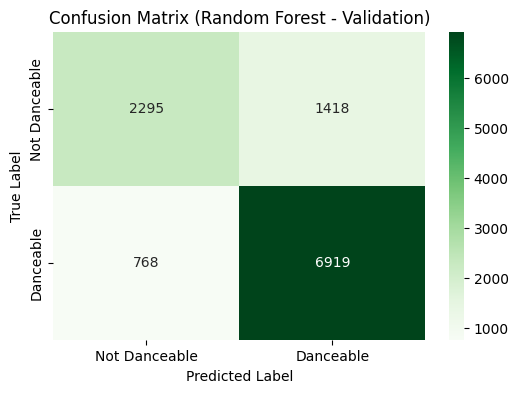

In [129]:
# Create Confusion Matrix
conf_matrix_rf = confusion_matrix(y_val, y_val_pred_rf)

# Create Heat Map of Confusion Matrix
plt.figure(figsize = (6, 4))
sns.heatmap(conf_matrix_rf, annot = True, fmt = 'd', cmap = 'Greens', xticklabels = ['Not Danceable', 'Danceable'], yticklabels = ['Not Danceable', 'Danceable'])
plt.title('Confusion Matrix (Random Forest - Validation)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

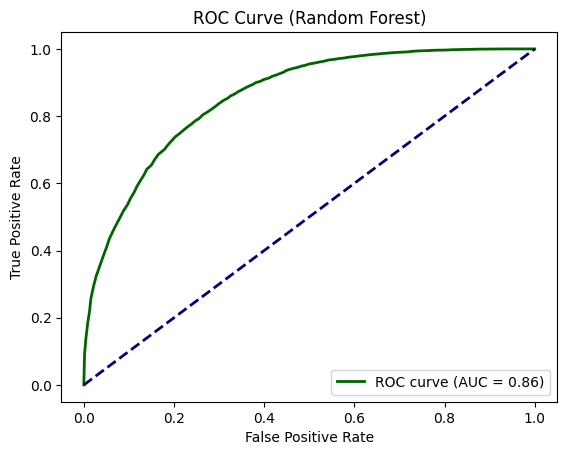

In [130]:
# Calculate ROC Metrics
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_val, y_val_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC Curve
plt.figure()
plt.plot(fpr_rf, tpr_rf, color = 'darkgreen', lw=2, label = f'ROC curve (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Random Forest)')
plt.legend(loc = "lower right")
plt.show()

### CV and Threshol Optimization

In [131]:
# Cross-Validation
cv_auc_rf = cross_val_score(rf, X_val, y_val, cv = 5, scoring = 'roc_auc')
print("5-Fold Cross-Validation AUC Scores (Random Forest):", cv_auc_rf)
print("Mean AUC (Random Forest):", np.mean(cv_auc_rf))

# Optimal Threshold
optimal_threshold_rf = 0.4
print("Optimal Threshold (Random Forest):", optimal_threshold_rf)

5-Fold Cross-Validation AUC Scores (Random Forest): [0.76018375 0.73475754 0.7699544  0.7174955  0.76018887]
Mean AUC (Random Forest): 0.7485160144133377
Optimal Threshold (Random Forest): 0.4


In [132]:
thresholds_rf

array([ inf, 1.  , 0.99, 0.98, 0.97, 0.96, 0.95, 0.94, 0.93, 0.92, 0.91,
       0.9 , 0.89, 0.88, 0.87, 0.86, 0.85, 0.84, 0.83, 0.82, 0.81, 0.8 ,
       0.79, 0.78, 0.77, 0.76, 0.75, 0.74, 0.73, 0.72, 0.71, 0.7 , 0.69,
       0.68, 0.67, 0.66, 0.65, 0.64, 0.63, 0.62, 0.61, 0.6 , 0.59, 0.58,
       0.57, 0.56, 0.55, 0.54, 0.53, 0.52, 0.51, 0.5 , 0.49, 0.48, 0.47,
       0.46, 0.45, 0.44, 0.43, 0.42, 0.41, 0.4 , 0.39, 0.38, 0.37, 0.36,
       0.35, 0.34, 0.33, 0.32, 0.31, 0.3 , 0.29, 0.28, 0.27, 0.26, 0.25,
       0.24, 0.23, 0.22, 0.21, 0.2 , 0.19, 0.18, 0.17, 0.16, 0.15, 0.14,
       0.13, 0.12, 0.11, 0.1 , 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03,
       0.02, 0.01, 0.  ])

The decision to use the optimal threshold is based on maximizing the True Positive Rate (TPR) from the ROC curve, ensuring the model captures as many positive cases (e.g., "danceable" tracks) as possible. This approach is suitable when recall is prioritized, such as any applications where missing true positives would be more costly than false positives. Additionally, cross-validation is used to validate the model's robustness and calculate the mean AUC, providing confidence in its ability to generalize across new different/relevant datasets.

# Clustering

In [133]:
# Convert to Numerical Representation
train_df['track_genre'], genre_mapping = pd.factorize(train_df['track_genre'])

# Fit the Scaler on the Numerical Features to Transform Data
ss = StandardScaler()
spotify_ss = ss.fit_transform(train_df[numerical_features])
spotify_ss

array([[-2.1064015 ,  1.39325375,  0.10055866, ...,  0.01667133,
         1.14815635, -0.83067995],
       [-0.4711414 ,  0.87844715, -1.96793235, ..., -0.52433798,
        -0.66127431, -0.43125338],
       [ 0.71813868, -0.76893395, -1.80626672, ..., -0.16029433,
        -0.80046128,  0.45715234],
       ...,
       [-0.96667476, -0.56301131, -2.21250344, ..., -0.60371973,
        -1.26972022, -0.89686663],
       [ 0.22260531, -1.7561513 , -1.719216  , ..., -0.71495529,
        -1.22995251, -1.93639859],
       [ 0.42081866, -0.45399344, -1.84771945, ..., -0.59006809,
        -1.18620803,  0.16934057]])

In [134]:
# Check Number of Genres
n_clusters = len(train_df['track_genre'].unique())
n_clusters

57

In [135]:
# Calculate Means of Numerical Features
genre_means = train_df.groupby('track_genre')[numerical_features].mean()

# Convert the Means to an Array for Initial Centroids
initial_centroids = genre_means.to_numpy()
initial_centroids

array([[ 4.25633333e+01,  5.43900000e-01,  4.26629667e-01,
        -9.53953333e+00,  4.21906667e-02,  5.67784688e-01,
         3.48562012e-02,  1.53043667e-01,  4.18992833e-01,
         1.19722038e+02],
       [ 4.50166667e+01,  3.72297000e-01,  2.42361833e-01,
        -1.85443783e+01,  4.13730000e-02,  7.77272923e-01,
         6.74325008e-01,  1.28412167e-01,  1.69042000e-01,
         1.11657575e+02],
       [ 4.88683333e+01,  5.45189000e-01,  6.67630833e-01,
        -8.04911833e+00,  8.56758333e-02,  2.73414639e-01,
         2.68726288e-01,  1.97380667e-01,  4.42242833e-01,
         1.23307720e+02],
       [ 4.44050000e+01,  5.67218333e-01,  6.17131667e-01,
        -7.69134500e+00,  9.69560000e-02,  3.30038206e-01,
         1.73838908e-02,  2.86022500e-01,  4.77278000e-01,
         1.20499187e+02],
       [ 4.42100000e+01,  5.07288833e-01,  5.02969450e-01,
        -1.05999233e+01,  4.98401667e-02,  4.39462419e-01,
         1.94885021e-01,  1.70469833e-01,  4.50417667e-01,
         1.

In [136]:
# Check Scaled Numerical Features of First Song
spotify_ss[0]

array([-2.1064015 ,  1.39325375,  0.10055866,  0.64676095, -0.45931697,
        0.23497118, -0.4136147 ,  0.01667133,  1.14815635, -0.83067995])

## KMeans

In [137]:
# Perform KMeans Clustering
kmeans = KMeans(n_clusters = n_clusters, init = initial_centroids)
y_kmeans = kmeans.fit_predict(spotify_ss)
kmeans.cluster_centers_

array([[-1.18407004, -1.44404369,  1.44844085, -2.9814769 , -0.17039225,
         1.47229939,  2.62352603,  3.54048994, -1.82106484, -1.03974703],
       [ 0.26773988,  0.9732945 , -0.26602953, -0.43813839, -0.17125881,
        -0.6939536 ,  2.44865359, -0.48370942, -0.94667304, -0.01492053],
       [ 0.07511615, -0.01945458,  0.7468768 ,  0.49114867, -0.17059716,
        -0.69160841, -0.37817856, -0.18878611,  1.17710918,  1.18635394],
       [-0.11021611,  1.0703328 ,  0.46130193,  0.33305883, -0.24214362,
        -0.38766212, -0.36368702, -0.30013529,  1.39996428, -0.14586381],
       [-0.76295549, -2.47277553, -1.69737194, -2.60859089,  0.66818757,
        -0.59494681,  2.18046045,  0.11800805, -1.71226675, -0.93002905],
       [ 0.30954686,  1.18894755, -0.77148205, -0.49957282, -0.19172996,
         0.59980838, -0.36643152, -0.3816318 ,  1.22833217, -0.15832632],
       [-0.01293168, -0.629976  ,  0.81093967,  0.47643558,  0.12066555,
        -0.68976707, -0.36980154,  2.7472224 

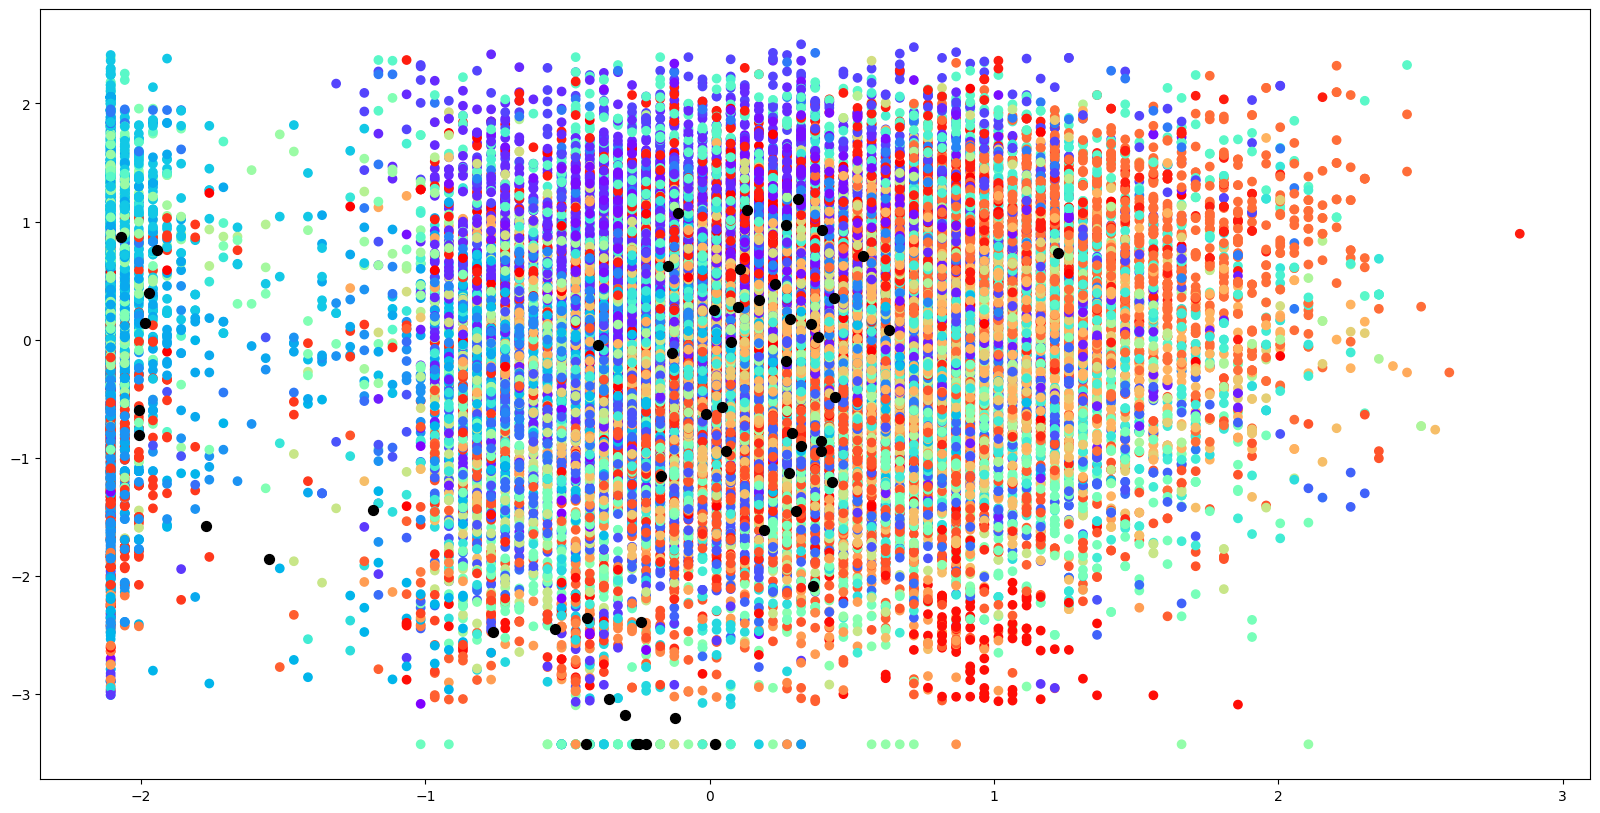

[[-1.18407004 -1.44404369  1.44844085 -2.9814769  -0.17039225  1.47229939
   2.62352603  3.54048994 -1.82106484 -1.03974703]
 [ 0.26773988  0.9732945  -0.26602953 -0.43813839 -0.17125881 -0.6939536
   2.44865359 -0.48370942 -0.94667304 -0.01492053]
 [ 0.07511615 -0.01945458  0.7468768   0.49114867 -0.17059716 -0.69160841
  -0.37817856 -0.18878611  1.17710918  1.18635394]
 [-0.11021611  1.0703328   0.46130193  0.33305883 -0.24214362 -0.38766212
  -0.36368702 -0.30013529  1.39996428 -0.14586381]
 [-0.76295549 -2.47277553 -1.69737194 -2.60859089  0.66818757 -0.59494681
   2.18046045  0.11800805 -1.71226675 -0.93002905]
 [ 0.30954686  1.18894755 -0.77148205 -0.49957282 -0.19172996  0.59980838
  -0.36643152 -0.3816318   1.22833217 -0.15832632]
 [-0.01293168 -0.629976    0.81093967  0.47643558  0.12066555 -0.68976707
  -0.36980154  2.7472224  -0.24283933  0.322633  ]
 [ 0.2894998  -0.78924156 -1.2089262  -0.44660604 -0.46002137  1.31280823
  -0.35543713 -0.37231108 -0.77999365 -1.20401557]
 

In [138]:
# Visualize the Clusters and Cluster Centers
centroids = kmeans.cluster_centers_
plt.figure(figsize = (20,10))

# Using Average Drive and Fairway
plt.scatter(spotify_ss[:,0], spotify_ss[:,1], c = y_kmeans, cmap = 'rainbow')
plt.scatter(centroids[:, 0], centroids[:, 1], c = 'black', s = 50)
plt.show()

print(centroids)

In [139]:
# Extract the Names of Artists
names = train_df[['artists']]

# Print CLuster Labels
print(kmeans.labels_)

# Group and Display Similar Songs/Artists Together
label = pd.DataFrame(kmeans.labels_.reshape(34199,1), columns = ['labels'])
combined = pd.concat([names, label], axis = 1)
list(combined.groupby('labels')['artists'].unique())

[16 40 41 ... 14  7 40]


[array(['Meditation Rain Sounds;Massage Tribe;Perfect Meditation;Relaxing Water Sounds',
        'Outside Broadcast Recordings', 'Nature Sounds', 'Rain Sounds',
        'White Noise for Babies', 'Rain Sounds XLE Library',
        'Silent Knights',
        'The Sleep Helpers;Meditation Relaxation Club;Zen Music Garden',
        'Deep Sleep', 'Deep Sleep Rain Sounds',
        'Rain Sounds;Rain Sounds & White Noise;Relaxing Rain Sounds;Meditation Rain Sounds;Sleep Sound Library;Sleep Sounds of Nature',
        'Ocean Sounds;Ocean Waves For Sleep', 'ASMR HD',
        'Fondo de la lectura', 'Flor de Loto'], dtype=object),
 array(['Bicep', 'Aphex Twin', 'AL-90;FMSAO', 'Elea;Bahramji',
        'Christian Löffler;Fejká', 'Bicep;Four Tet',
        'Christian Löffler;Henry Green', 'Boards of Canada',
        'Fejká;Rökkurró', 'Dine', 'Solar Fields', 'Fery', 'Kupla',
        'Kijugo', 'Kensuke Ushio', 'Musicality;mellowthemanic', 'Otaku',
        'Musicality', 'Kato', 'Yuki Hayashi;Asami Tachiban


## Agglomerative

Note: Below this is another hierarchical sampling, with another kmeans, as doing clustering with the entirety of the data overloaded the RAM.

In [140]:
# Take Sample of 1000 Data Points
sample_indices = np.random.choice(len(spotify_ss), size = 1000, replace = False)
spotify_sample = spotify_ss[sample_indices]

# Run K-Means on the Sample
kmeans = KMeans(n_clusters = 10)
y_kmeans_sample = kmeans.fit_predict(spotify_sample)

# Run Agglomerative Clustering on the Same Sample
hclust = AgglomerativeClustering(n_clusters = 10, metric = 'euclidean', linkage = 'ward')
spotify_hclust_labels = hclust.fit_predict(spotify_sample)

## Comparison of KMeans and Agglomerative Clustering

In [141]:
# Calculate and Print Rand Score
rand_score(y_kmeans_sample, spotify_hclust_labels)

0.8750610610610611

In [142]:
# Scale and Transform the New Sample
train_df_h = train_df[numerical_features].sample(1000)
h_ss = StandardScaler()
spotify_h_ss = h_ss.fit_transform(train_df_h)

# Run Agglomerative Clustering on the New Sample
hclust = AgglomerativeClustering(n_clusters = 10, metric = 'euclidean', linkage = 'ward')
spotify_hclust_labels = hclust.fit(spotify_h_ss).labels_

### Performance Metrics

In [143]:
# Calculate and Print Inertia
kmeans.inertia_

4435.212397026097

In [144]:
# Calculate and Print Silhouette Score for KMeans
silhouette_score(spotify_ss, y_kmeans)

0.11876127552254129

In [145]:
# Calculate and Print Silhouette Score for Hierarchical Clustering
silhouette_score(spotify_h_ss ,spotify_hclust_labels)

0.11916655381152352

# Neural Network

In [146]:
# Assign KMeans Cluster to Data
train_df['cluster'] = y_kmeans
train_df

,track_id,artists,popularity,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,cluster
0,3Hn3LfhrQOaKihdCibJsTs,Jason Mraz,0,231266,0.796,0.667,-4.831,0.0392,0.381000,0.000000,0.2210,0.754,97.988,4,0,16
1,0N7UyDRbyHe2L63ilYDcRK,Andrew Foy;Renee Foy,33,211358,0.711,0.168,-16.504,0.0367,0.868000,0.000020,0.1140,0.299,109.937,4,0,40
2,6VtoP2sJt5oCmPOQIve2sf,Boyce Avenue,57,276146,0.439,0.207,-9.573,0.0297,0.608000,0.000000,0.1860,0.264,136.514,4,0,41
3,3x3zdepy3au5Uo81WIA9MG,John Frusciante,51,228426,0.498,0.113,-16.097,0.0333,0.691000,0.000287,0.1080,0.296,168.383,4,0,40
4,1pIMxRddmCGalHnRbLFkWg,Jason Mraz,53,226098,0.643,0.617,-4.950,0.0410,0.194000,0.000000,0.0989,0.592,82.029,4,0,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34194,2Cj5LxM6O2HWQIr9p9h3TH,for KING & COUNTRY;Kirk Franklin;Tori Kelly,59,206103,0.389,0.784,-4.389,0.1300,0.203000,0.000011,0.2010,0.484,178.093,4,56,27
34195,6M391pAp3LXdjQurMdyDkv,Planetshakers,43,261992,0.502,0.900,-6.692,0.0489,0.000177,0.000009,0.4510,0.339,128.002,4,56,42
34196,5Rh0IO9XOuKDcLU71Qd1yp,Lucas Cervetti,23,523893,0.473,0.109,-17.631,0.0315,0.976000,0.896000,0.0983,0.146,96.008,4,56,14
34197,4v3j3mqjPX0p7uohes7edY,Kathryn Scott,47,252920,0.276,0.228,-11.879,0.0291,0.876000,0.000000,0.0763,0.156,64.910,3,56,7


In [147]:
# Features and Target Setup (Cluster Derived From KMeans)
selected_features = ['danceability', 'energy', 'valence', 'tempo', 'loudness']
target = 'cluster'

# Scale and Transform Samples
ss = StandardScaler()
train_df[selected_features] = ss.fit_transform(train_df[selected_features])

# Encode Target as Integers
train_df[target] = train_df[target].astype('category').cat.codes

# Set Train and Test Splits
X_train, X_test, y_train, y_test = train_test_split(train_df[selected_features], train_df[target], test_size = 0.2, random_state = 42)

# Convert Data to Tensors
X_train = torch.tensor(X_train.values, dtype = torch.float32)
X_test = torch.tensor(X_test.values, dtype = torch.float32)
y_train = torch.tensor(y_train.values, dtype = torch.long)
y_test = torch.tensor(y_test.values, dtype = torch.long)

# Define the Neural Network Class
class SongClusterNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SongClusterNN, self).__init__()
        self.lay1 = nn.Linear(input_size, hidden_size)
        self.lay2 = nn.Linear(hidden_size, hidden_size)
        self.lay3 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.relu(self.lay1(x))
        x = self.dropout(x)
        x = F.relu(self.lay2(x))
        x = self.dropout(x)
        x = self.lay3(x)
        return x

# Create Datasets and Dataloaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

# Initialize Model
input_size = len(selected_features)
hidden_size = 64
output_size = train_df[target].nunique()
model = SongClusterNN(input_size, hidden_size, output_size)

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

Epoch [1/20], Train Loss: 2.1683, Train Acc: 0.3504, Top-5 Acc: 0.7811, Test Loss: 1.7761, Test Acc: 0.4420, Top-5 Acc: 0.8737
Epoch [2/20], Train Loss: 1.9521, Train Acc: 0.3927, Top-5 Acc: 0.8273, Test Loss: 1.7684, Test Acc: 0.4443, Top-5 Acc: 0.8798
Epoch [3/20], Train Loss: 1.9130, Train Acc: 0.4025, Top-5 Acc: 0.8378, Test Loss: 1.6988, Test Acc: 0.4558, Top-5 Acc: 0.8855
Epoch [4/20], Train Loss: 1.8990, Train Acc: 0.4052, Top-5 Acc: 0.8368, Test Loss: 1.6966, Test Acc: 0.4623, Top-5 Acc: 0.8860
Epoch [5/20], Train Loss: 1.8910, Train Acc: 0.4055, Top-5 Acc: 0.8387, Test Loss: 1.7013, Test Acc: 0.4484, Top-5 Acc: 0.8833
Epoch [6/20], Train Loss: 1.8816, Train Acc: 0.4076, Top-5 Acc: 0.8440, Test Loss: 1.7078, Test Acc: 0.4513, Top-5 Acc: 0.8854
Epoch [7/20], Train Loss: 1.8799, Train Acc: 0.4088, Top-5 Acc: 0.8425, Test Loss: 1.6913, Test Acc: 0.4551, Top-5 Acc: 0.8930
Epoch [8/20], Train Loss: 1.8762, Train Acc: 0.4117, Top-5 Acc: 0.8443, Test Loss: 1.7053, Test Acc: 0.4491, To

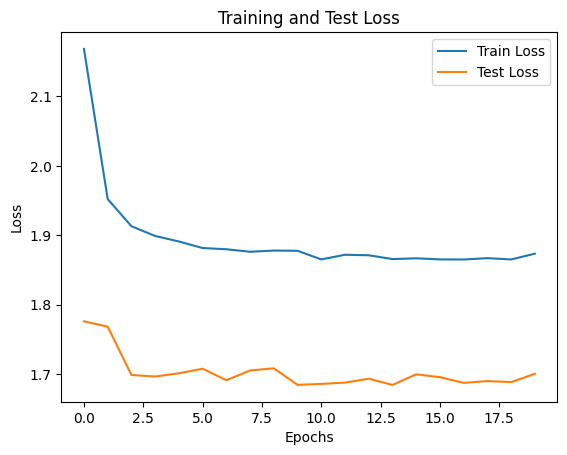

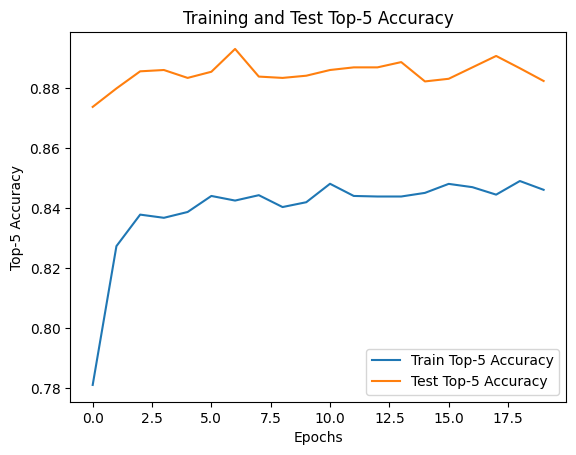

In [148]:
# Custom Top-K Accuracy Function
def top_k_accuracy(outputs, targets, k = 5):

    # Get Top-K Predicted Clusters
    _, top_k_preds = torch.topk(outputs, k, dim = 1)

    # Check if Targets are in Top-K Predictions
    correct = top_k_preds.eq(targets.view(-1, 1)).sum().item()

    # Return the Top-K Accuracy (Float)
    return correct / targets.size(0)

# Training Loop with Top-5 Accuracy
epochs = 20
train_losses, test_losses = [], []
train_top5_acc, test_top5_acc = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    top5_correct = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        correct += (outputs.argmax(1) == y_batch).sum().item()
        top5_correct += top_k_accuracy(outputs, y_batch, k = 5) * X_batch.size(0)

    train_loss = running_loss / len(X_train)
    train_acc = correct / len(X_train)
    train_top5 = top5_correct / len(X_train)
    train_losses.append(train_loss)
    train_top5_acc.append(train_top5)

    # Evaluate on Test Set
    model.eval()
    test_loss, correct, top5_correct = 0.0, 0, 0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item() * X_batch.size(0)
            correct += (outputs.argmax(1) == y_batch).sum().item()
            top5_correct += top_k_accuracy(outputs, y_batch, k=5) * X_batch.size(0)

    test_loss /= len(X_test)
    test_acc = correct / len(X_test)
    test_top5 = top5_correct / len(X_test)
    test_losses.append(test_loss)
    test_top5_acc.append(test_top5)

    print(f"Epoch [{epoch+1}/{epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Top-5 Acc: {train_top5:.4f}, "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, Top-5 Acc: {test_top5:.4f}")

# Plot Training and Test Loss
plt.plot(train_losses, label = "Train Loss")
plt.plot(test_losses, label = "Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Test Loss")
plt.legend()
plt.show()

# Plot Top-5 Accuracy
plt.plot(train_top5_acc, label = "Train Top-5 Accuracy")
plt.plot(test_top5_acc, label = "Test Top-5 Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Top-5 Accuracy")
plt.title("Training and Test Top-5 Accuracy")
plt.legend()
plt.show()

In [149]:
def recommend_song(input_song_features, model, train_df, n_recommendations = 5):

    input_song_scaled = ss.transform([input_song_features])
    input_song_tensor = torch.tensor(input_song_scaled, dtype = torch.float32)
    model.eval()

    with torch.no_grad():
        predicted_cluster = torch.argmax(model(input_song_tensor)).item()

    # Filter Songs in the Predicted Cluster
    cluster_songs = train_df[train_df['cluster'] == predicted_cluster]
    recommendations = cluster_songs.sample(n = min(n_recommendations, len(cluster_songs)))
    return recommendations[['artists', 'track_id']]

In [150]:
# Set Song Features (Randomly)
new_song_features = np.random.rand(len(selected_features))

# Calculate Recommended Songs
recommended_songs = recommend_song(new_song_features, model, train_df)

print("Recommended Songs")
print(recommended_songs)

Recommended Songs
                                           artists                track_id
18183                                     Jay Chou  3hsZxEXf0PNXVq0S8idacb
12965                   Ozzy Osbourne;Eric Clapton  2lcfGO79t1PqcXc2Mbxyd5
5580             Cookie Monsta;Flux Pavilion;Koven  3N6B80cmfOnaQGG7KWppyb
31707                                      LGHTNNG  3sWOKLWbe02RdNIQVb9sbv
14949  Pritam;Arijit Singh;Ash King;Shashwat Singh  4rIv0uUnxs5hVZfe5t9SNs


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
